<a href="https://colab.research.google.com/github/subhabrata-ghosh-1988/Gesture-Recognition/blob/main/Gesture%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
## Import libraries
import numpy as np
import os
from scipy import misc
from imageio import imread
import cv2
from skimage import transform,io
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
import shutil
import abc


In [2]:
import glob, os , shutil
for f in glob.glob("/content/model_init*"):
    shutil.rmtree(f)

In [3]:
## remove the existing zip file
shutil.rmtree('/content/Project_data.zip', ignore_errors=True)

In [4]:
## Initiate the file download
!pip install gdown
import gdown
url="https://drive.google.com/uc?id=1kM4V7pnLjGbuCaDpfBNHig99gr2rdqyJ"
output = "Project_data.zip"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1kM4V7pnLjGbuCaDpfBNHig99gr2rdqyJ
To: /content/Project_data.zip
1.71GB [00:11, 143MB/s]


'Project_data.zip'

In [5]:
## unzip the downloaded folder
shutil.rmtree('/content/Project_data', ignore_errors=True)
shutil.unpack_archive("Project_data.zip", "Project_data")

We set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
tf.compat.v1.disable_eager_execution()

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.**

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [8]:
# the entire dataset is placed in below directory
main_folder='/content/Project_data/Project_data'

In [9]:
## Checking current TF version
tf.version.VERSION

'2.4.1'

### Plotting

In [10]:
import matplotlib.pyplot as plt
def plot(Model):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(Model.history['loss'])   
    axes[0].plot(Model.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(Model.history['categorical_accuracy'])   
    axes[1].plot(Model.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
import gc
class GCCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          print(gc.collect())

In [12]:
# referred ABC library use case from this link https://riptutorial.com/python/example/23083/why-how-to-use-abcmeta-and--abstractmethod

class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_src_path(self,main_folder):
        self.train_doc = np.random.permutation(open(main_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(main_folder + '/' + 'val.csv').readlines())
        self.train_path = main_folder + '/' + 'train'
        self.val_path =  main_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=40,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=transform.resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=transform.resize(cropped,(self.image_height,self.image_width,3))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR , GCCallback()]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    def clear_session(self, model):
        del model
        gc.collect()
        tf.keras.backend.clear_session()
        tf.compat.v1.reset_default_graph() # TF graph isn't same as Keras graph

    @abc.abstractmethod
    def define_model(self):
        pass


## Sample Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [13]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
Conv3D1=ModelConv3D1()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=160,image_width=160)
Conv3D1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=1)
Conv3D1_model=Conv3D1.define_model()
Conv3D1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

In [15]:
Conv3D1.train_model(Conv3D1_model)

23/23 [==============================] - ETA: 0s - batch: 11.0000 - size: 28.8261 - loss: 1.4912 - categorical_accuracy: 0.4284
Epoch 00001: saving model to model_init_2021-03-2108_26_18.607216/model-00001-1.49124-0.42836-4.86878-0.21000.h5
0
23/23 [==============================] - 274s 11s/step - batch: 11.0000 - size: 28.8261 - loss: 1.4912 - categorical_accuracy: 0.4284 - val_loss: 4.8688 - val_categorical_accuracy: 0.2100


In [16]:
Conv3D1.clear_session(Conv3D1_model)

In [17]:
Conv3D1_bs40=ModelConv3D1()
Conv3D1_bs40.initialize_src_path(main_folder)
Conv3D1_bs40.initialize_image_properties(image_height=160,image_width=160)
Conv3D1_bs40.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
Conv3D1_model_bs40=Conv3D1_bs40.define_model()
Conv3D1_model_bs40.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

#### Got below memory exhaust error with image resolution of 160x160, 30 frames and a batch_size of 40
ResourceExhaustedError:  OOM when allocating tensor with shape[40,16,15,80,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_2/max_pooling3d_8/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-11-c85facc09113>:122) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_7489]

In [18]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


In [19]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - batch: 11.0000 - size: 28.8261 - loss: 1.4302 - categorical_accuracy: 0.4540
Epoch 00001: saving model to model_init_2021-03-2108_31_06.879816/model-00001-1.43021-0.45400-2.03139-0.21000.h5
0
23/23 [==============================] - 161s 7s/step - batch: 11.0000 - size: 28.8261 - loss: 1.4302 - categorical_accuracy: 0.4540 - val_loss: 2.0314 - val_categorical_accuracy: 0.2100
Epoch 2/3
23/23 [==============================] - ETA: 0s - batch: 11.0000 - size: 28.8261 - loss: 0.9001 - categorical_accuracy: 0.6621
Epoch 00002: saving model to model_init_2021-03-2108_31_06.879816/model-00002-0.90008-0.66214-4.21787-0.17000.h5
0
23/23 [==============================] - 121s 5s/step - batch: 11.0000 - size: 28.8261 - loss: 0.9001 - categorical_accuracy: 0.6621 - val_loss: 4.2179 - val_categorical_accuracy: 0.1700
Epoch 3/3
23/23 [==============================] - ETA: 0s - batch: 11.0000 - size: 28.8261 - loss

In [20]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - batch: 11.0000 - size: 28.8261 - loss: 1.6461 - categorical_accuracy: 0.3771
Epoch 00001: saving model to model_init_2021-03-2108_37_54.227943/model-00001-1.64606-0.37707-1.90597-0.18000.h5
48
23/23 [==============================] - 230s 10s/step - batch: 11.0000 - size: 28.8261 - loss: 1.6461 - categorical_accuracy: 0.3771 - val_loss: 1.9060 - val_categorical_accuracy: 0.1800
Epoch 2/2
23/23 [==============================] - ETA: 0s - batch: 11.0000 - size: 28.8261 - loss: 1.2087 - categorical_accuracy: 0.5596
Epoch 00002: saving model to model_init_2021-03-2108_37_54.227943/model-00002-1.20872-0.55958-2.55964-0.26000.h5
0
23/23 [==============================] - 197s 9s/step - batch: 11.0000 - size: 28.8261 - loss: 1.2087 - categorical_accuracy: 0.5596 - val_loss: 2.5596 - val_categorical_accuracy: 0.2600


In [21]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - batch: 5.5000 - size: 55.2500 - loss: 1.6515 - categorical_accuracy: 0.3529 
Epoch 00001: saving model to model_init_2021-03-2108_45_03.333779/model-00001-1.65146-0.35294-1.57691-0.27000.h5
48
12/12 [==============================] - 231s 19s/step - batch: 5.5000 - size: 55.2500 - loss: 1.6515 - categorical_accuracy: 0.3529 - val_loss: 1.5769 - val_categorical_accuracy: 0.2700
Epoch 2/2
12/12 [==============================] - ETA: 0s - batch: 5.5000 - size: 55.2500 - loss: 1.1992 - categorical_accuracy: 0.5505 
Epoch 00002: saving model to model_init_2021-03-2108_45_03.333779/model-00002-1.19918-0.55053-2.01046-0.19000.h5
0
12/12 [==============================] - 202s 18s/step - batch: 5.5000 - size: 55.2500 - loss: 1.1992 - categorical_accuracy: 0.5505 - val_loss: 2.0105 - val_categorical_accuracy: 0.1900


In [22]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - batch: 5.5000 - size: 55.2500 - loss: 1.6753 - categorical_accuracy: 0.4057
Epoch 00001: saving model to model_init_2021-03-2108_52_18.162235/model-00001-1.67529-0.40573-1.59577-0.30000.h5
48
12/12 [==============================] - 128s 10s/step - batch: 5.5000 - size: 55.2500 - loss: 1.6753 - categorical_accuracy: 0.4057 - val_loss: 1.5958 - val_categorical_accuracy: 0.3000
Epoch 2/2
11/12 [==========================>...] - ETA: 8s - batch: 5.0000 - size: 60.0000 - loss: 1.2168 - categorical_accuracy: 0.5136 
Epoch 00002: saving model to model_init_2021-03-2108_52_18.162235/model-00002-1.23956-0.51282-2.23712-0.17000.h5
0
12/12 [==============================] - 107s 10s/step - batch: 5.5000 - size: 55.2500 - loss: 1.2396 - categorical_accuracy: 0.5128 - val_loss: 2.2371 - val_categorical_accuracy: 0.1700


In [23]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - ETA: 0s - batch: 4.0000 - size: 73.6667 - loss: 1.7428 - categorical_accuracy: 0.3620 
Epoch 00001: saving model to model_init_2021-03-2108_56_15.459566/model-00001-1.74278-0.36199-1.69829-0.21000.h5
48
9/9 [==============================] - 125s 13s/step - batch: 4.0000 - size: 73.6667 - loss: 1.7428 - categorical_accuracy: 0.3620 - val_loss: 1.6983 - val_categorical_accuracy: 0.2100
Epoch 2/2
9/9 [==============================] - ETA: 0s - batch: 4.0000 - size: 73.6667 - loss: 1.1840 - categorical_accuracy: 0.5400 
Epoch 00002: saving model to model_init_2021-03-2108_56_15.459566/model-00002-1.18396-0.53997-3.00948-0.16000.h5
0
9/9 [==============================] - 108s 13s/step - batch: 4.0000 - size: 73.6667 - loss: 1.1840 - categorical_accuracy: 0.5400 - val_loss: 3.0095 - val_categorical_accuracy: 0.1600


In [24]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - batch: 22.0000 - size: 14.7333 - loss: 1.5440 - categorical_accuracy: 0.4118
Epoch 00001: saving model to model_init_2021-03-2109_00_10.907179/model-00001-1.54404-0.41176-4.48453-0.16000.h5
48
45/45 [==============================] - 266s 6s/step - batch: 22.0000 - size: 14.7333 - loss: 1.5440 - categorical_accuracy: 0.4118 - val_loss: 4.4845 - val_categorical_accuracy: 0.1600
Epoch 2/2
45/45 [==============================] - ETA: 0s - batch: 22.0000 - size: 14.7333 - loss: 1.2099 - categorical_accuracy: 0.5611
Epoch 00002: saving model to model_init_2021-03-2109_00_10.907179/model-00002-1.20990-0.56109-6.74839-0.26000.h5
0
45/45 [==============================] - 225s 5s/step - batch: 22.0000 - size: 14.7333 - loss: 1.2099 - categorical_accuracy: 0.5611 - val_loss: 6.7484 - val_categorical_accuracy: 0.2600


In [25]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - batch: 22.0000 - size: 14.7333 - loss: 1.5820 - categorical_accuracy: 0.4027
Epoch 00001: saving model to model_init_2021-03-2109_08_24.499191/model-00001-1.58195-0.40271-6.01646-0.16000.h5
48
45/45 [==============================] - 143s 3s/step - batch: 22.0000 - size: 14.7333 - loss: 1.5820 - categorical_accuracy: 0.4027 - val_loss: 6.0165 - val_categorical_accuracy: 0.1600
Epoch 2/2
45/45 [==============================] - ETA: 0s - batch: 22.0000 - size: 14.7333 - loss: 1.0770 - categorical_accuracy: 0.6078
Epoch 00002: saving model to model_init_2021-03-2109_08_24.499191/model-00002-1.07701-0.60784-12.25964-0.21000.h5
0
45/45 [==============================] - 122s 3s/step - batch: 22.0000 - size: 14.7333 - loss: 1.0770 - categorical_accuracy: 0.6078 - val_loss: 12.2596 - val_categorical_accuracy: 0.2100


In [26]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - ETA: 0s - batch: 22.0000 - size: 14.7333 - loss: 1.6018 - categorical_accuracy: 0.3876
Epoch 00001: saving model to model_init_2021-03-2109_12_51.659582/model-00001-1.60176-0.38763-3.83403-0.16000.h5
48
45/45 [==============================] - 124s 3s/step - batch: 22.0000 - size: 14.7333 - loss: 1.6018 - categorical_accuracy: 0.3876 - val_loss: 3.8340 - val_categorical_accuracy: 0.1600
Epoch 2/2
45/45 [==============================] - ETA: 0s - batch: 22.0000 - size: 14.7333 - loss: 1.1296 - categorical_accuracy: 0.5475
Epoch 00002: saving model to model_init_2021-03-2109_12_51.659582/model-00002-1.12957-0.54751-5.04227-0.14000.h5
0
45/45 [==============================] - 105s 2s/step - batch: 22.0000 - size: 14.7333 - loss: 1.1296 - categorical_accuracy: 0.5475 - val_loss: 5.0423 - val_categorical_accuracy: 0.1400


In [27]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.5822 - categorical_accuracy: 0.3801 
Epoch 00001: saving model to model_init_2021-03-2109_16_42.514505/model-00001-1.58219-0.38009-4.92011-0.21000.h5
48
67/67 [==============================] - 124s 2s/step - batch: 33.0000 - size: 9.8955 - loss: 1.5822 - categorical_accuracy: 0.3801 - val_loss: 4.9201 - val_categorical_accuracy: 0.2100
Epoch 2/2
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.1958 - categorical_accuracy: 0.5309 
Epoch 00002: saving model to model_init_2021-03-2109_16_42.514505/model-00002-1.19579-0.53092-7.04926-0.22000.h5
0
67/67 [==============================] - 105s 2s/step - batch: 33.0000 - size: 9.8955 - loss: 1.1958 - categorical_accuracy: 0.5309 - val_loss: 7.0493 - val_categorical_accuracy: 0.2200


In [28]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.5933 - categorical_accuracy: 0.4208 
Epoch 00001: saving model to model_init_2021-03-2109_20_33.533250/model-00001-1.59332-0.42081-6.02739-0.16000.h5
48
67/67 [==============================] - 225s 3s/step - batch: 33.0000 - size: 9.8955 - loss: 1.5933 - categorical_accuracy: 0.4208 - val_loss: 6.0274 - val_categorical_accuracy: 0.1600
Epoch 2/2
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.1371 - categorical_accuracy: 0.5581 
Epoch 00002: saving model to model_init_2021-03-2109_20_33.533250/model-00002-1.13714-0.55807-10.45722-0.17000.h5
0
67/67 [==============================] - 202s 3s/step - batch: 33.0000 - size: 9.8955 - loss: 1.1371 - categorical_accuracy: 0.5581 - val_loss: 10.4572 - val_categorical_accuracy: 0.1700


In [29]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.6431 - categorical_accuracy: 0.3756 
Epoch 00001: saving model to model_init_2021-03-2109_27_42.910688/model-00001-1.64306-0.37557-11.39790-0.16000.h5
48
67/67 [==============================] - 265s 4s/step - batch: 33.0000 - size: 9.8955 - loss: 1.6431 - categorical_accuracy: 0.3756 - val_loss: 11.3979 - val_categorical_accuracy: 0.1600
Epoch 2/2
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.2571 - categorical_accuracy: 0.5158 
Epoch 00002: saving model to model_init_2021-03-2109_27_42.910688/model-00002-1.25708-0.51584-15.40731-0.16000.h5
0
67/67 [==============================] - 227s 3s/step - batch: 33.0000 - size: 9.8955 - loss: 1.2571 - categorical_accuracy: 0.5158 - val_loss: 15.4073 - val_categorical_accuracy: 0.1600


In [30]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.5755 - categorical_accuracy: 0.4012 
Epoch 00001: saving model to model_init_2021-03-2109_35_56.896391/model-00001-1.57553-0.40121-2.34058-0.30000.h5
48
67/67 [==============================] - 144s 2s/step - batch: 33.0000 - size: 9.8955 - loss: 1.5755 - categorical_accuracy: 0.4012 - val_loss: 2.3406 - val_categorical_accuracy: 0.3000
Epoch 2/2
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.2382 - categorical_accuracy: 0.5083 
Epoch 00002: saving model to model_init_2021-03-2109_35_56.896391/model-00002-1.23819-0.50830-3.09266-0.23000.h5
0
67/67 [==============================] - 123s 2s/step - batch: 33.0000 - size: 9.8955 - loss: 1.2382 - categorical_accuracy: 0.5083 - val_loss: 3.0927 - val_categorical_accuracy: 0.2300


In [31]:
conv_3d1.clear_session(conv_3d1_model)
conv_3d1=ModelConv3D1()
conv_3d1.initialize_src_path(main_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - ETA: 0s - batch: 8.0000 - size: 39.0000 - loss: 1.6114 - categorical_accuracy: 0.3967
Epoch 00001: saving model to model_init_2021-03-2109_40_25.844948/model-00001-1.61140-0.39668-2.02471-0.21000.h5
48
17/17 [==============================] - 144s 8s/step - batch: 8.0000 - size: 39.0000 - loss: 1.6114 - categorical_accuracy: 0.3967 - val_loss: 2.0247 - val_categorical_accuracy: 0.2100
Epoch 2/2
17/17 [==============================] - ETA: 0s - batch: 8.0000 - size: 39.0000 - loss: 1.0988 - categorical_accuracy: 0.5732
Epoch 00002: saving model to model_init_2021-03-2109_40_25.844948/model-00002-1.09876-0.57315-5.65281-0.21000.h5
0
17/17 [==============================] - 125s 8s/step - batch: 8.0000 - size: 39.0000 - loss: 1.0988 - categorical_accuracy: 0.5732 - val_loss: 5.6528 - val_categorical_accuracy: 0.2100


### Observation

**As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size.**

So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

## Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [32]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
conv_3d1.clear_session(conv_3d1_model)
Conv3D1=ModelConv3D1()
Conv3D1.initialize_src_path(main_folder)
Conv3D1.initialize_image_properties(image_height=160,image_width=160)
Conv3D1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
Conv3D1_model=Conv3D1.define_model()
Conv3D1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 80, 80, 32)    1

In [34]:
print("Total Params:", Conv3D1_model.count_params())
accuracy_check_model_1 = Conv3D1.train_model(Conv3D1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - batch: 8.0000 - size: 39.0000 - loss: 1.5218 - categorical_accuracy: 0.4314
Epoch 00001: saving model to model_init_2021-03-2109_44_56.788820/model-00001-1.52181-0.43137-1.53799-0.31000.h5
48
17/17 [==============================] - 182s 10s/step - batch: 8.0000 - size: 39.0000 - loss: 1.5218 - categorical_accuracy: 0.4314 - val_loss: 1.5380 - val_categorical_accuracy: 0.3100
Epoch 2/15
17/17 [==============================] - ETA: 0s - batch: 8.0000 - size: 39.0000 - loss: 0.9892 - categorical_accuracy: 0.6169
Epoch 00002: saving model to model_init_2021-03-2109_44_56.788820/model-00002-0.98919-0.61689-2.06962-0.23000.h5
0
17/17 [==============================] - 155s 10s/step - batch: 8.0000 - size: 39.0000 - loss: 0.9892 - categorical_accuracy: 0.6169 - val_loss: 2.0696 - val_categorical_accuracy: 0.2300
Epoch 3/15
17/17 [==============================] - ETA: 0s - batch: 8.0000 - size: 39.0000 - los

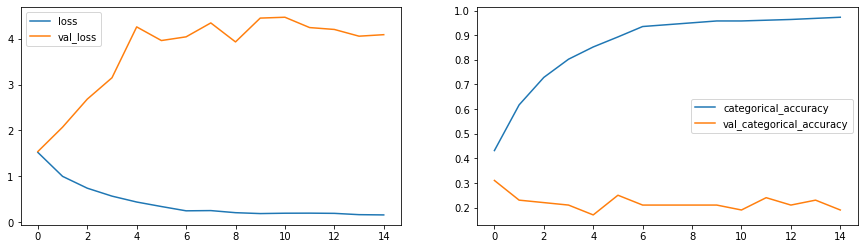

In [35]:
plot(accuracy_check_model_1)

#### Model is clearly overfitting. So we need to do data augmentation

## Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [36]:
Conv3D1.clear_session(Conv3D1_model)
Conv3D2=ModelConv3D1()
Conv3D2.initialize_src_path(main_folder)
Conv3D2.initialize_image_properties(image_height=160,image_width=160)
Conv3D2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
Conv3D2_model=Conv3D2.define_model(dense_neurons=256,dropout=0.5)
Conv3D2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 80, 80, 32)    1

In [37]:
print("Total Params:", Conv3D2_model.count_params())
accuracy_check_model_2=Conv3D2.train_model(Conv3D2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 39.0000 - loss: 1.9587 - categorical_accuracy: 0.3869
Epoch 00001: saving model to model_init_2021-03-2110_24_03.959552/model-00001-1.95875-0.38688-1.97477-0.35000.h5
48
34/34 [==============================] - 312s 9s/step - batch: 16.5000 - size: 39.0000 - loss: 1.9587 - categorical_accuracy: 0.3869 - val_loss: 1.9748 - val_categorical_accuracy: 0.3500
Epoch 2/25
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 39.0000 - loss: 1.4944 - categorical_accuracy: 0.5045
Epoch 00002: saving model to model_init_2021-03-2110_24_03.959552/model-00002-1.49443-0.50452-5.45264-0.23000.h5
0
34/34 [==============================] - 281s 8s/step - batch: 16.5000 - size: 39.0000 - loss: 1.4944 - categorical_accuracy: 0.5045 - val_loss: 5.4526 - val_categorical_accuracy: 0.2300
Epoch 3/25
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 39.0000 - 

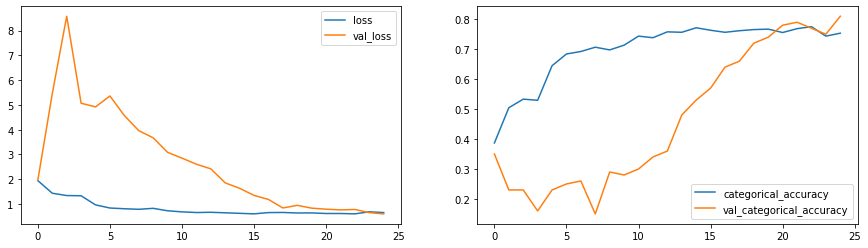

In [38]:
plot(accuracy_check_model_2)

Model is not overfitting and we get a best validation accuracy of ~80% and training accuracy of ~82%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002

In [39]:
Conv3D2.clear_session(Conv3D2_model)

## Model 3 - Reduce filter size to (2,2,2) and image res to 120 x 120

In [40]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:

Conv3D3=ModelConv3D3()
Conv3D3.initialize_src_path(main_folder)
Conv3D3.initialize_image_properties(image_height=120,image_width=120)
Conv3D3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
Conv3D3_model=Conv3D3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
Conv3D3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 32)     1

In [ ]:
##tf.compat.v1.enable_eager_execution()
print(tf.executing_eagerly())
print("Total Params:", Conv3D3_model.count_params())
accuracy_check_model_3=Conv3D3.train_model(Conv3D3_model,augment_data=True)

False
Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - batch: 11.0000 - size: 57.6522 - loss: 2.2907 - categorical_accuracy: 0.3265
Epoch 00001: saving model to model_init_2021-03-2112_22_51.590771/model-00001-2.29074-0.32655-1.77032-0.20000.h5
48
23/23 [==============================] - 222s 9s/step - batch: 11.0000 - size: 57.6522 - loss: 2.2907 - categorical_accuracy: 0.3265 - val_loss: 1.7703 - val_categorical_accuracy: 0.2000
Epoch 2/30
23/23 [==============================] - ETA: 0s - batch: 11.0000 - size: 57.6522 - loss: 1.6408 - categorical_accuracy: 0.4721
Epoch 00002: saving model to model_init_2021-03-2112_22_51.590771/model-00002-1.64077-0.47210-2.51669-0.20000.h5
0
23/23 [==============================] - 204s 9s/step - batch: 11.0000 - size: 57.6522 - loss: 1.6408 - categorical_accuracy: 0.4721 - val_loss: 2.5167 - val_categorical_accuracy: 0.2000
Epoch 3/30
23/23 [==============================] - ETA: 0s - batch: 11.0000 - size: 57.6

In [ ]:
plot(accuracy_check_model_3)

This Model has a best validation accuracy of 68% and training accuracy of 68% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

In [ ]:
Conv3D3.clear_session(Conv3D3_model)

## Model 4 - Adding more layers

In [ ]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D4=ModelConv3D4()
Conv3D4.initialize_src_path(main_folder)
Conv3D4.initialize_image_properties(image_height=120,image_width=120)
Conv3D4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
Conv3D4_model=Conv3D4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
Conv3D4_model.summary()

In [ ]:
print("Total Params:", Conv3D4_model.count_params())
accuracy_check_model_4=Conv3D4.train_model(Conv3D4_model,augment_data=True)

In [ ]:
plot(accuracy_check_model_4)

With more layers we see some performance improvement. We get a best validation accuracy of 73% . Let's try adding dropouts at the convolution layers

## Model 5 Adding dropout at convolution layers

In [ ]:
Conv3D4.clear_session(Conv3D4_model)
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D5=ModelConv3D5()
Conv3D5.initialize_src_path(main_folder)
Conv3D5.initialize_image_properties(image_height=120,image_width=120)
Conv3D5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
Conv3D5_model=Conv3D5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
Conv3D5_model.summary()

In [ ]:
print("Total Params:", Conv3D5_model.count_params())
accuracy_check_model_5=Conv3D5.train_model(Conv3D5_model,augment_data=True)

In [ ]:
plot(accuracy_check_model_5)


Adding dropouts has further reduced validation accuracy as its not to learn generalizable features
All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

In [ ]:
Conv3D5.clear_session(Conv3D5_model)

## Model 6 - reducing the number of parameters

In [ ]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
Conv3D6=ModelConv3D6()
Conv3D6.initialize_src_path(main_folder)
Conv3D6.initialize_image_properties(image_height=100,image_width=100)
Conv3D6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
Conv3D6_model=Conv3D6.define_model(dense_neurons=128,dropout=0.25)
Conv3D6_model.summary()

In [ ]:
tprint("Total Params:", Conv3D6_model.count_params())
accuracy_check_model_6=Conv3D6.train_model(Conv3D6_model,augment_data=True)

In [ ]:
plot(accuracy_check_model_6)

For the above low memory foot print model the best validation accuracy of 73%

In [ ]:
Conv3D6.clear_session(Conv3D6_model)

## Model 7 - reducing the number of parameters

In [ ]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_src_path(main_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

In [ ]:
print("Total Params:", conv_3d7_model.count_params())
accuracy_check_model_7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

In [ ]:
plot(accuracy_check_model_7)

In [ ]:
conv_3d7.clear_session(conv_3d7_model)

## Model 8 - reducing the number of parameters

In [ ]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_src_path(main_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

In [ ]:
print("Total Params:", conv_3d8_model.count_params())
accuracy_check_model_8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

In [ ]:
plot(accuracy_check_model_8)

In [ ]:
conv_3d8.clear_session(conv_3d8_model)

## Model 9 - CNN- LSTM Model

In [ ]:
class CNNRNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
cnn_rnn1=CNNRNN1()
cnn_rnn1.initialize_src_path(main_folder)
cnn_rnn1.initialize_image_properties(image_height=120,image_width=120)
cnn_rnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
cnn_rnn1_model=cnn_rnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnn_rnn1_model.summary()

In [ ]:
print("Total Params:", cnn_rnn1_model.count_params())
accuracy_check_model_9=cnn_rnn1.train_model(cnn_rnn1_model,augment_data=True)

In [ ]:
plot(accuracy_check_model_9)

In [ ]:
cnn_rnn1.clear_session(cnn_rnn1_model)

## Applying More Augmentation

In [ ]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_src_path(self,main_folder):
        self.train_doc = np.random.permutation(open(main_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(main_folder + '/' + 'val.csv').readlines())
        self.train_path = main_folder + '/' + 'train'
        self.val_path =  main_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=transform.resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=transform.resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                  
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model 10 - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [ ]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_src_path(main_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

In [ ]:
print("Total Params:", conv_3d10_model.count_params())
accuracy_check_model_10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

In [ ]:
plot(accuracy_check_model_10)

In [ ]:
conv_3d10.clear_session(conv_3d10_model)

## Model 11 - (2,2,2) Filter & 120x120 Image resolution - similar to Model 3

In [ ]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_src_path(main_folder)
conv_3d11.initialize_image_properties(image_height=160,image_width=160)
conv_3d11.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

In [ ]:
print("Total Params:", conv_3d11_model.count_params())
accuracy_check_model_11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

In [ ]:
plot(accuracy_check_model_11)

In [ ]:
conv_3d11.clear_session(conv_3d11_model)